# Description

This notebook explores a the GLS model used in PhenoPLIER (Generalized Least Squares) to associate an LV (gene weights) with a trait's gene associations (gene p-values).
Since predicted gene expression is correlated among closeby genes, a GLS model is expected to capture this and adjust LVs with highly correlated genes at the top.

Here we used the entire correlation matrix (all gene-gene correlations per chromosome).

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "no_covars"
    / "_corrs_all"
    / "gls-gtex_v8_mashr-full_corr"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results):
    lv_code = None
    lvs = results["lv"].unique()
    if lvs.shape[0] == 1:
        lv_code = lvs[0]

    traits = results["phenotype"].unique()

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = qqplot(results[PVALUE_COLUMN])
        if lvs.shape[0] == 1:
            ax.set_title(f"{lv_code} - {traits.shape[0]} traits")
        else:
            ax.set_title(f"{lvs.shape[0]} LVs - {traits.shape[0]} traits")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-gtex_v8_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV391,0.095357,0.002236,42.655095,0.000000,0.000000,random.pheno988
1,LV405,0.153258,0.048444,3.163623,0.001565,0.000783,random.pheno988
2,LV585,0.300793,0.096952,3.102509,0.001927,0.000964,random.pheno988
3,LV426,0.377903,0.121979,3.098111,0.001956,0.000978,random.pheno988
4,LV516,0.129552,0.044405,2.917501,0.003541,0.001770,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.052656534954407294

# QQ-plot

/opt/code/libs/phenoplier_plots.py:13: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(obs_data)


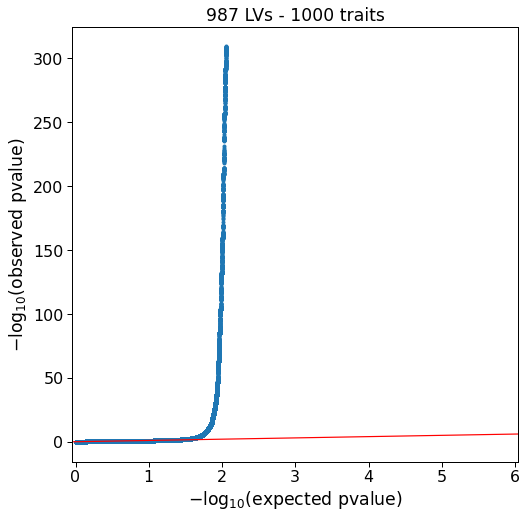

In [18]:
qqplot_unif(dfs)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.161,0.214,0.273
1,LV10,0.004,0.022,0.044
2,LV100,0.004,0.016,0.038
3,LV101,0.001,0.012,0.034
4,LV102,0.005,0.027,0.046


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.031777,0.052657,0.079012
std,0.095027,0.099314,0.099658
min,0.000000,0.000000,0.000000
25%,0.003000,0.018000,0.040000
50%,0.005000,0.025000,0.052000
75%,0.009000,0.033000,0.066000
max,0.550000,0.554000,0.554000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(5, 4)

,lv,1,5,10
839,LV855,0.017,0.049,0.086
191,LV271,0.015,0.050,0.083
796,LV816,0.012,0.050,0.102
434,LV490,0.011,0.051,0.096
704,LV733,0.020,0.051,0.104


,lv,1,5,10
839,LV855,0.017,0.049,0.086
191,LV271,0.015,0.050,0.083
796,LV816,0.012,0.050,0.102
434,LV490,0.011,0.051,0.096
704,LV733,0.020,0.051,0.104


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(118, 4)

,lv,1,5,10
981,LV983,0.55,0.554,0.554
656,LV690,0.55,0.554,0.554
253,LV327,0.55,0.554,0.554
513,LV561,0.55,0.554,0.554
37,LV132,0.55,0.554,0.554
694,LV724,0.55,0.554,0.554
708,LV737,0.55,0.554,0.554
71,LV163,0.55,0.554,0.554
518,LV566,0.55,0.554,0.554
535,LV581,0.55,0.554,0.554


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
876,LV45,-0.150049,0.112132,-1.338151,0.180894,0.909553,random.pheno988
1307,LV45,0.041677,0.127200,0.327648,0.743189,0.371594,random.pheno589
2311,LV45,0.040053,0.104403,0.383634,0.701263,0.350631,random.pheno385
3378,LV45,0.008229,0.107589,0.076484,0.939036,0.469518,random.pheno5
4717,LV45,-0.081607,0.296182,-0.275529,0.782918,0.608541,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.005

In [32]:
show_prop(results, 0.05)

0.022

In [33]:
show_prop(results, 0.10)

0.045

In [34]:
show_prop(results, 0.15)

0.084

In [35]:
show_prop(results, 0.20)

0.118

### QQplot

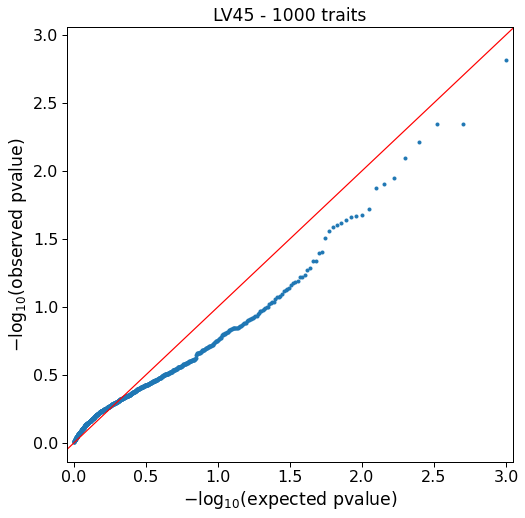

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
563,LV234,-0.024206,0.135142,-0.179118,0.857851,0.571075,random.pheno988
1858,LV234,-0.155380,0.153270,-1.013765,0.310733,0.844633,random.pheno589
2925,LV234,-0.218342,0.125782,-1.735869,0.082635,0.958683,random.pheno385
3771,LV234,-0.113768,0.129641,-0.877556,0.380217,0.809891,random.pheno5
4266,LV234,0.051406,0.356913,0.144029,0.885482,0.442741,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.006

In [43]:
show_prop(results, 0.05)

0.026

In [44]:
show_prop(results, 0.10)

0.056

In [45]:
show_prop(results, 0.15)

0.079

In [46]:
show_prop(results, 0.20)

0.112

### QQplot

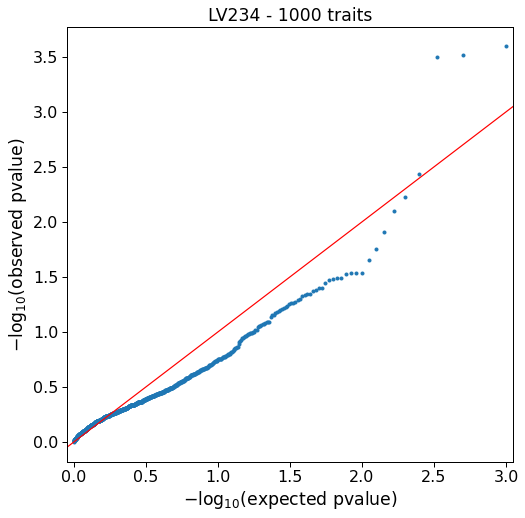

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
490,LV847,-0.003924,0.129546,-0.030293,0.975834,0.512083,random.pheno988
1779,LV847,-0.106969,0.146928,-0.728035,0.466619,0.766691,random.pheno589
2725,LV847,-0.072742,0.120598,-0.603174,0.546414,0.726793,random.pheno385
3480,LV847,-0.009878,0.124280,-0.079482,0.936652,0.531674,random.pheno5
4518,LV847,-0.027108,0.342133,-0.079231,0.936851,0.531574,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.041

In [55]:
show_prop(results, 0.10)

0.075

In [56]:
show_prop(results, 0.15)

0.111

In [57]:
show_prop(results, 0.20)

0.15

### QQplot

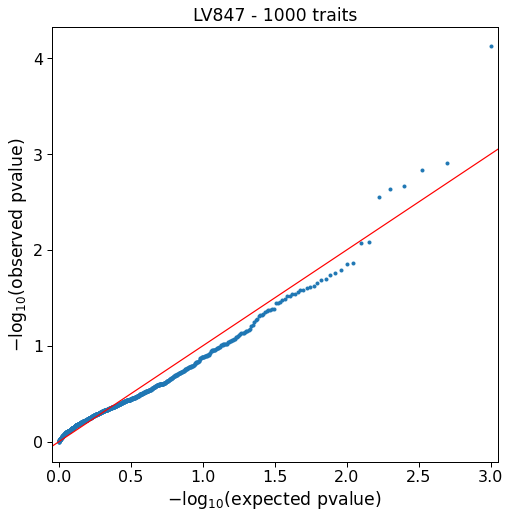

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
937,LV110,-0.249699,0.120341,-2.074925,0.038033,0.980983,random.pheno988
1818,LV110,-0.117278,0.136532,-0.858976,0.390386,0.804807,random.pheno589
2906,LV110,-0.165612,0.112051,-1.478010,0.139454,0.930273,random.pheno385
3652,LV110,-0.059505,0.115486,-0.515262,0.606387,0.696806,random.pheno5
4830,LV110,-0.150181,0.317924,-0.472381,0.636671,0.681665,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.006

In [65]:
show_prop(results, 0.05)

0.019

In [66]:
show_prop(results, 0.10)

0.04

In [67]:
show_prop(results, 0.15)

0.074

In [68]:
show_prop(results, 0.20)

0.111

### QQplot

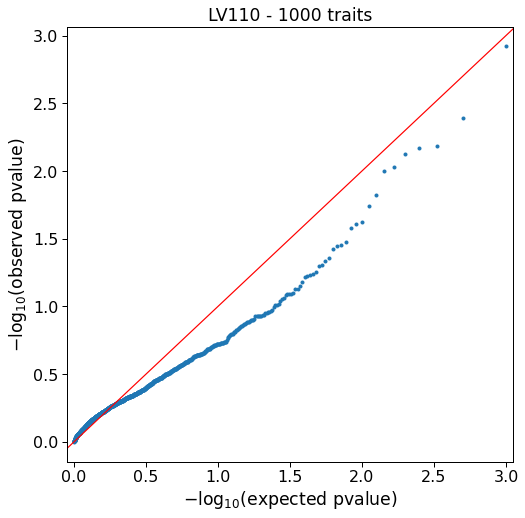

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
366,LV769,0.013842,0.081104,0.170673,0.864486,0.432243,random.pheno988
1843,LV769,-0.089645,0.091984,-0.974567,0.329812,0.835094,random.pheno589
2839,LV769,-0.078253,0.075498,-1.036484,0.300015,0.849992,random.pheno385
3216,LV769,0.048066,0.077805,0.617778,0.536744,0.268372,random.pheno5
4876,LV769,-0.137365,0.214191,-0.641318,0.521339,0.739331,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.005

In [76]:
show_prop(results, 0.05)

0.023

In [77]:
show_prop(results, 0.10)

0.052

In [78]:
show_prop(results, 0.15)

0.08

In [79]:
show_prop(results, 0.20)

0.1

### QQplot

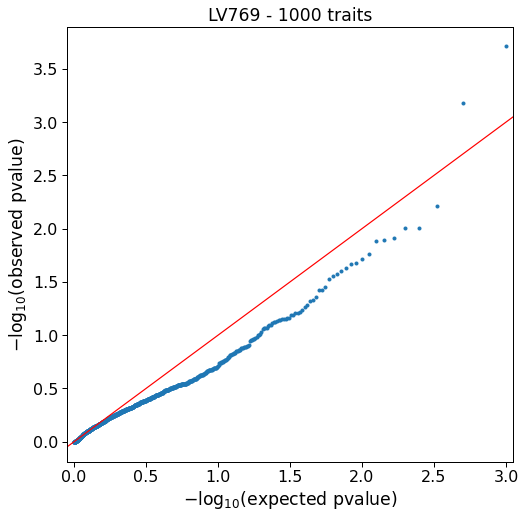

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
187,LV800,0.099651,0.131130,0.759941,0.447318,0.223659,random.pheno988
1415,LV800,0.008957,0.148738,0.060223,0.951980,0.475990,random.pheno589
2613,LV800,-0.035759,0.122081,-0.292913,0.769598,0.615201,random.pheno385
3801,LV800,-0.130787,0.125795,-1.039685,0.298525,0.850737,random.pheno5
4249,LV800,0.055965,0.346332,0.161594,0.871631,0.435815,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.005

In [87]:
show_prop(results, 0.05)

0.039

In [88]:
show_prop(results, 0.10)

0.07

In [89]:
show_prop(results, 0.15)

0.096

In [90]:
show_prop(results, 0.20)

0.122

### QQplot

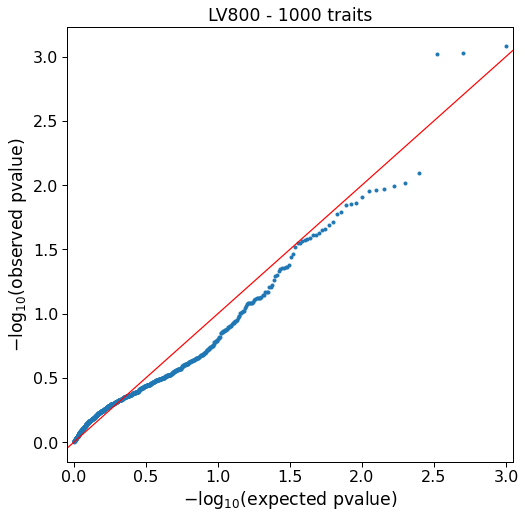

In [91]:
qqplot_unif(results)

## LV806

In [92]:
lv_code = "LV806"

In [93]:
results = dfs[dfs["lv"] == lv_code]

In [94]:
results.shape

(1000, 7)

In [95]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
895,LV806,-0.171987,0.116083,-1.481583,0.138500,0.930750,random.pheno988
1292,LV806,0.046979,0.131686,0.356747,0.721293,0.360646,random.pheno589
2153,LV806,0.100218,0.108080,0.927262,0.353825,0.176913,random.pheno385
3866,LV806,-0.156898,0.111367,-1.408837,0.158932,0.920534,random.pheno5
4312,LV806,0.031475,0.306631,0.102649,0.918245,0.459122,random.pheno74


In [96]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [97]:
show_prop(results, 0.01)

0.003

In [98]:
show_prop(results, 0.05)

0.015

In [99]:
show_prop(results, 0.10)

0.035

In [100]:
show_prop(results, 0.15)

0.059

In [101]:
show_prop(results, 0.20)

0.09

### QQplot

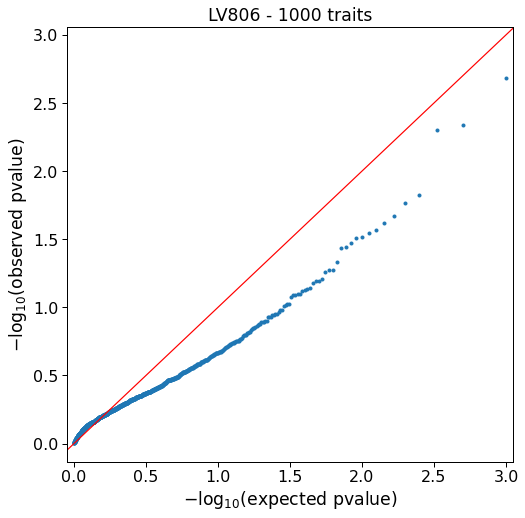

In [102]:
qqplot_unif(results)

# LVs with expected mean type I error

In [103]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
839,LV855,0.017,0.049,0.086
191,LV271,0.015,0.050,0.083
796,LV816,0.012,0.050,0.102
434,LV490,0.011,0.051,0.096
704,LV733,0.020,0.051,0.104


In [104]:
lv_results_expected = {}

## LV412

In [105]:
lv_code = "LV412"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
809,LV412,-0.095357,0.102247,-0.932606,0.351058,0.824471,random.pheno988
1520,LV412,-0.006932,0.115980,-0.059772,0.952339,0.523830,random.pheno589
2376,LV412,0.020384,0.095194,0.214130,0.830452,0.415226,random.pheno385
3628,LV412,-0.042742,0.098097,-0.435711,0.663061,0.668469,random.pheno5
4065,LV412,0.129289,0.270051,0.478758,0.632127,0.316064,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.026

In [112]:
show_prop(results, 0.10)

0.048

In [113]:
show_prop(results, 0.15)

0.071

In [114]:
show_prop(results, 0.20)

0.103

### QQplot

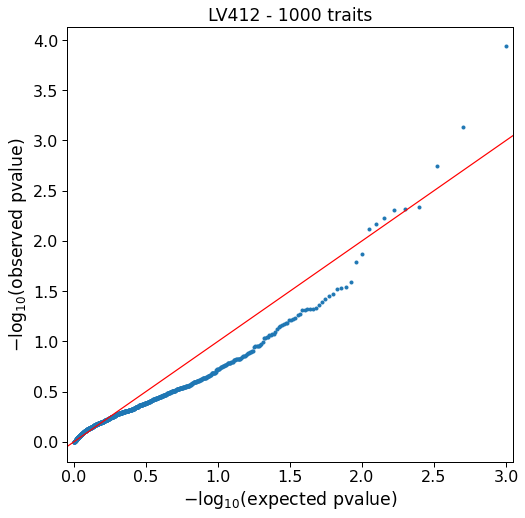

In [115]:
qqplot_unif(results)

## LV57

In [116]:
lv_code = "LV57"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
381,LV57,0.018861,0.134171,0.140573,0.888212,0.444106,random.pheno988
1680,LV57,-0.063653,0.152179,-0.418280,0.675757,0.662122,random.pheno589
2177,LV57,0.100992,0.124901,0.808574,0.418790,0.209395,random.pheno385
3100,LV57,0.128929,0.128707,1.001723,0.316515,0.158258,random.pheno5
4340,LV57,0.025025,0.354348,0.070624,0.943699,0.471850,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.002

In [122]:
show_prop(results, 0.05)

0.024

In [123]:
show_prop(results, 0.10)

0.05

In [124]:
show_prop(results, 0.15)

0.085

In [125]:
show_prop(results, 0.20)

0.118

### QQplot

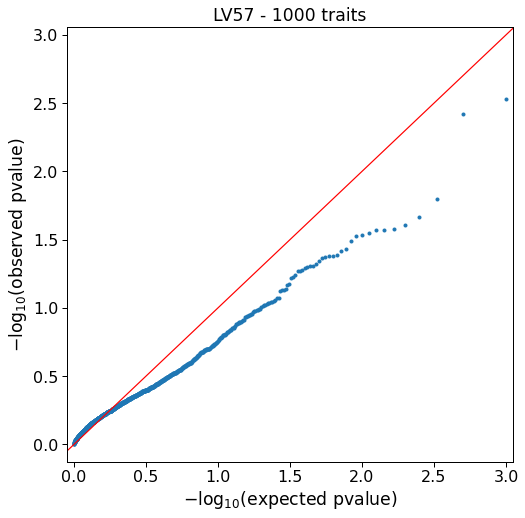

In [126]:
qqplot_unif(results)

## LV647

In [127]:
lv_code = "LV647"

In [128]:
results = dfs[dfs["lv"] == lv_code]

In [129]:
results.shape

(1000, 7)

In [130]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
527,LV647,-0.016184,0.127849,-0.126588,0.899271,0.550365,random.pheno988
1411,LV647,0.009655,0.145011,0.066579,0.946919,0.473459,random.pheno589
2573,LV647,-0.023711,0.119022,-0.199219,0.842098,0.578951,random.pheno385
3185,LV647,0.091674,0.122648,0.747455,0.454816,0.227408,random.pheno5
4687,LV647,-0.083070,0.337652,-0.246022,0.805673,0.597164,random.pheno74


In [131]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [132]:
show_prop(results, 0.01)

0.002

In [133]:
show_prop(results, 0.05)

0.022

In [134]:
show_prop(results, 0.10)

0.051

In [135]:
show_prop(results, 0.15)

0.091

In [136]:
show_prop(results, 0.20)

0.125

### QQplot

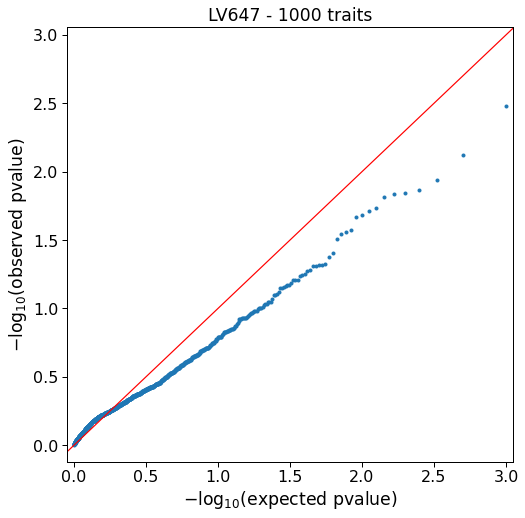

In [137]:
qqplot_unif(results)